In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#Stop warnings
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

In [23]:
data = pd.read_csv('Rossman Sales.csv')

In [24]:
data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [25]:
#Trying for one store first so only keeping store one first
finaldata = data[data['Store'] ==1]

In [26]:
finaldata.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1115,1,4,2015-07-30,5020,546,1,1,0,1
2230,1,3,2015-07-29,4782,523,1,1,0,1
3345,1,2,2015-07-28,5011,560,1,1,0,1
4460,1,1,2015-07-27,6102,612,1,1,0,1


In [27]:
final_train = finaldata.sample(frac=0.6, random_state=450411920)
final_test = finaldata[finaldata.index.isin(final_train.index)==False]
#Now we have final train/test which only has predictors whilst y_train/test are the response
y_train = final_train.pop('Sales')
y_test = final_test.pop('Sales')

# EDA

Inspiration taken from: https://www.kaggle.com/omarelgabry/a-journey-through-rossmann-stores

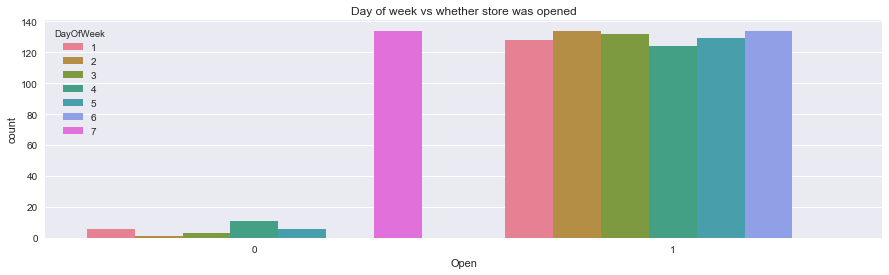

In [36]:
fig, (axis1) = plt.subplots(1,1,figsize=(15,4))
sns.countplot(x='Open', hue='DayOfWeek',data=finaldata,palette="husl", ax=axis1)
plt.title('Day of week vs whether store was opened')

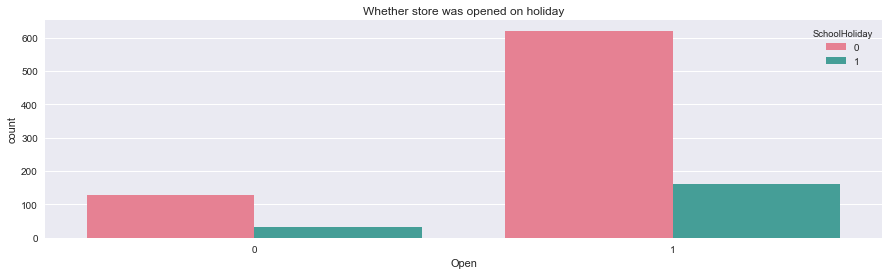

In [38]:
fig, (axis1) = plt.subplots(1,1,figsize=(15,4))
sns.countplot(x='Open', hue='SchoolHoliday',data=finaldata,palette="husl", ax=axis1)
plt.title('Whether store was opened on holiday')
#No school holiday is pink and school holiday is green

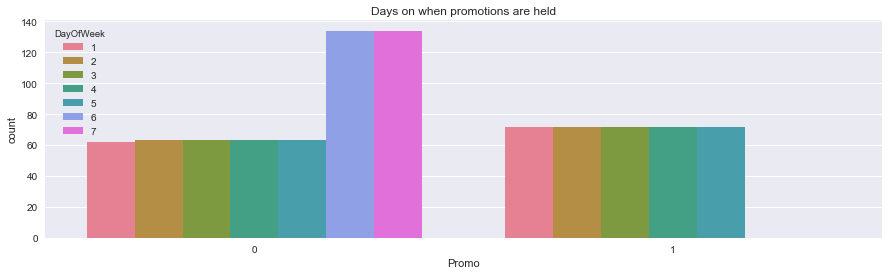

In [39]:
fig, (axis1) = plt.subplots(1,1,figsize=(15,4))
sns.countplot(x='Promo', hue='DayOfWeek',data=finaldata,palette="husl", ax=axis1)
plt.title('Days on when promotions are held')
#Promotion are spread over the days

In [41]:
finaldata['Year'] = finaldata['Date'].apply(lambda x: int(str(x)[:4]))
finaldata['Month'] = finaldata['Date'].apply(lambda x: int(str(x)[5:7]))

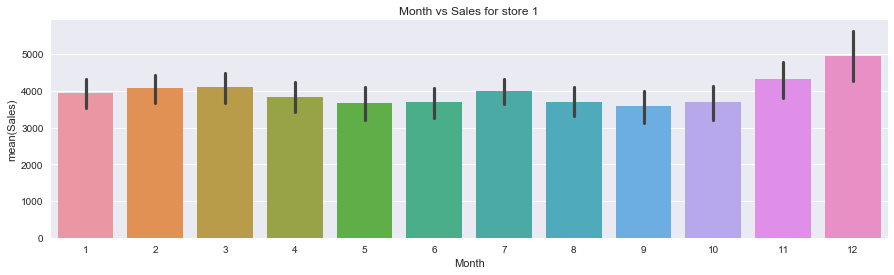

In [49]:
fig, (axis1) = plt.subplots(1,1,figsize=(15,4))
sns.barplot(x='Month',y='Sales', data=finaldata, ax=axis1)
plt.title('Month vs Sales for store 1')


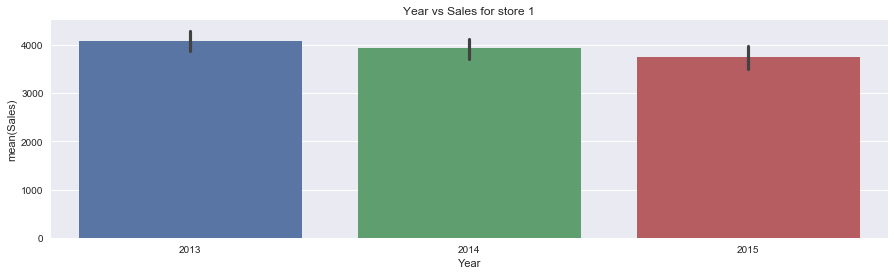

In [50]:
fig, (axis1) = plt.subplots(1,1,figsize=(15,4))
sns.barplot(x='Year',y='Sales', data=finaldata, ax=axis1)
plt.title('Year vs Sales for store 1')
